# 01 Embeddings and Vector Database

In this notebook, you will learn about embeddings and storing/retrieving/search through a Vector Database

In order to prepare data for LLM usage, there are several steps that converts your raw dataset into finetuning ready dataset.




## Tokenization
Tokenization is an important part of NLP. The way text data are split and passed will provide different result. A very simply tokenization may simply involve splitting a sentence into words:


In order to process a squence of data, in this case texts, we need to define what a token should be represented as.
<img >

### What are Embeddings?

Embeddings are representation of raw data as a numerical vectors in a certain dimensional space.


**Simple example of Embedding: One-Hot Encoding**


```python
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Sample data
data = np.array(['cat', 'dog', 'fish']).reshape(-1, 1)

# OneHotEncoder
encoder = OneHotEncoder(sparse=False)
onehot_encoded = encoder.fit_transform(data)

print(onehot_encoded)
```

<CONTENT ABOUT LLM EMBEDDINGS HERE>

Here are some code example of tiktoken based embeddings

cookbook: https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb


## LLM Model vs compatible embeddings

Here are some other types of embeddings and their respecting compatibly models

https://huggingface.co/learn/nlp-course/en/chapter6/5

https://docs.llamaindex.ai/en/stable/module_guides/models/llms/



## References
- https://towardsdatascience.com/the-evolution-of-tokenization-in-nlp-byte-pair-encoding-in-nlp-d7621b9c1186

# Various kind of Tokenization


- spaCy tokenization
- keras.preprocessing.text.tokenizer
- gensim tokenizer
- HuggingFace tokenizer
- tiktoken tokenizer


    cl100k_base: Gpt-4, Gpt-3.5-turbo, and Text-embedding-ada-002.
    p50k_base: Codex models, text-davinci-003 and text-davinci-002.
    r50k_base: GPT-3 models.#

## GPT-4o Embedding Example

In [ ]:
# 01 Embeddings and Vector Database
# Example code for token-based embeddings
import importlib
from pathlib import Path

import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))
filepath = Path("../../backend/assets/test/copypasta.txt")
enc = tiktoken.get_encoding("o200k_base")
assert enc.decode(enc.encode("hello world")) == "hello world"

# To get the tokeniser corresponding to a specific model in the OpenAI API:
enc = tiktoken.encoding_for_model("gpt-4o")

text = filepath.read_text()

encoded_text = enc.encode(text)
print(encoded_text)
print("total tokens:", len(enc.encode(text)))

# Byte-Pair Encoding

So what actually happens in `.encode()`?
Byte-Pair Encoding is a form of data compression that are commonly used in GPT and BART related models.

## Advantages

- It's reversible and lossless, so you can convert tokens back into the original text
- It works on arbitrary text, even text that is not in the tokeniser's training data
- It compresses the text: the token sequence is shorter than the bytes corresponding to the original text. On average, in practice, each token corresponds to about 4 bytes.
- It attempts to let the model see common subwords. For instance, "ing" is a common subword in English, so BPE encodings will often split "encoding" into tokens like "encod" and "ing" (instead of e.g. "enc" and "oding"). Because the model will then see the "ing" token again and again in different contexts, it helps models generalise and better understand grammar.

source: https://towardsdatascience.com/byte-pair-encoding-subword-based-tokenization-algorithm-77828a70bee0

### 1. Compute a unique set of words used in the corpus

In [ ]:
corpus = [
    "The weather is fine today.",
    "I am going to the park.",
    "The park is nearby where I live with my family and friends.",
    "Hopefully, you will be able to join us for a picnic.",
]


# pretokenizing
from tiktoken._educational import *

# Train a BPE tokeniser on a small amount of text
enc = train_simple_encoding()

# Visualise how the GPT-4 encoder encodes text
enc = SimpleBytePairEncoding.from_tiktoken("cl100k_base")
res = enc.encode(corpus[0])
assert enc.decode(enc.encode("hello world")) == "hello world"

## Preparing Texts for Embedding encoding

In [ ]:
from pathlib import Path

import pymupdf
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.milvus import Milvus

# Load the PDF document
pdf_path = Path("../../backend/assets/test/test.pdf")
pdf = pymupdf.open(pdf_path)

# Extract the text from the PDF
docs = ""
for page in pdf:
    docs += page.get_text()

# Close the PDF document
pdf.close()

# Split the documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=0)
all_splits = text_splitter.split_text(docs)
len(all_splits)

19

In [ ]:
from openai import client


# use model "gpt-3.5-turbo-instruct" for text
def generate_response_with_chatgpt(prompt):
    response = client.completions.create(
        model="gpt-4.o",  # Choose appropriate model
        prompt=prompt,
        max_tokens=150,
        n=1,
        stop=None,
        temperature=0.7,
    )
    return response.choices[0].text.strip()


# filename = "national-capitals.pdf"
# pdf_text = extract_text_from_pdf(filename)

print("Ready - ask questions or exit with q/Q:")
while True:
    user_query = input("==> ")
    if user_query.lower().strip() == "q":
        break
    prompt = pdf_text + "\n\n" + user_query
    response = generate_response_with_chatgpt(prompt)
    print("Response:\n")
    for line in textwrap.wrap(response, width=70):
        print(line)
    print("-" * 10)

## Ollama Embeddings

In [11]:


from llama_index.embeddings.ollama import OllamaEmbedding

ollama_embedding = OllamaEmbedding(
    model_name="llama3",
    base_url="http://localhost:11434",
    ollama_additional_kwargs={"mirostat": 0},
)

pass_embedding = ollama_embedding.get_text_embedding_batch(
    ["This is a passage!", "This is another passage"], show_progress=True
)
print(len(pass_embedding))

query_embedding = ollama_embedding.get_query_embedding("Where is blue?")
print(len(query_embedding))

Generating embeddings:   0%|          | 0/2 [00:00<?, ?it/s]

2
4096


# Huggingface Embeddings
source: https://huggingface.co/docs/chat-ui/en/configuration/embeddings

See all other embeddings type here:
https://docs.llamaindex.ai/en/stable/examples/embeddings/huggingface/

In [ ]:

from llama_index.embeddings.huggingface import HuggingFaceEmbedding

# loads BAAI/bge-small-en
# embed_model = HuggingFaceEmbedding()

# loads BAAI/bge-small-en-v1.5
embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-small-en-v1.5")

embeddings = embed_model.get_text_embedding("Hello World!")
print(len(embeddings))
print(embeddings[:5])

384
[-0.003275736467912793, -0.011690806597471237, 0.04155921936035156, -0.03814813494682312, 0.02418307028710842]


## Storing Embeddings in Vector Databases
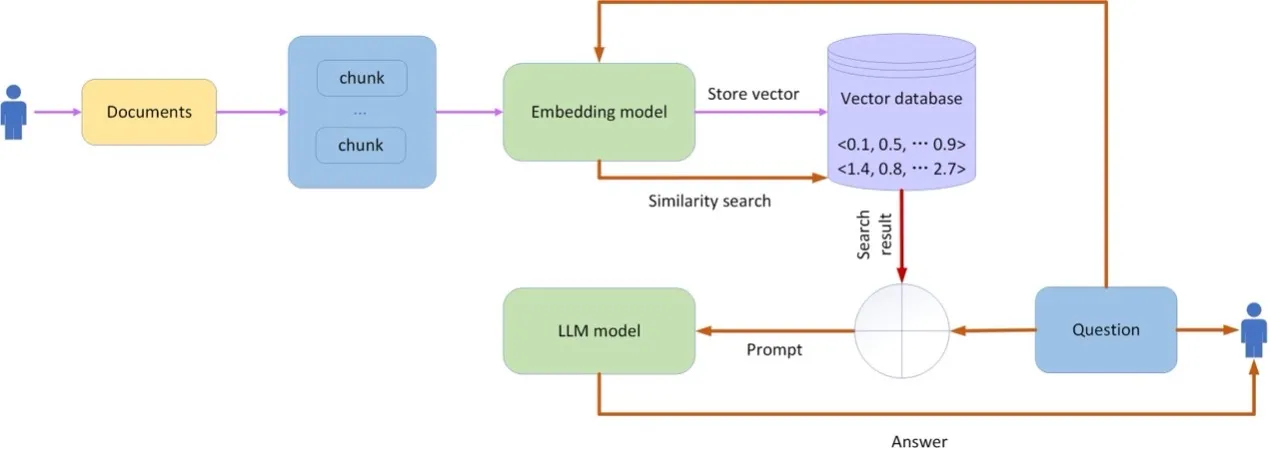

Instead of loading a document directly via the ChatUI, you may want to do a RAG prompt based off an existing maintained set of dataset.
This dataset may contain post-process real time data that you have gathered using other systems.

In order to do that, we need a vector database. One of the most common app to introduce to the concept of vector database is opensearch

## LlamaIndex

In this case, we will setup a basic LlamaIndex that uses tiktoken library as the core embedding library.

LlamaIndex is an in-memory vector database that can be ran locally. We will use this as a lightweight vector database


```markdown
## Simple LlamaIndex Example

In this section, we will create a simple LlamaIndex that consumes a PDF file. LlamaIndex is an in-memory vector database that can be run locally. We will use this as a lightweight vector database to store and retrieve embeddings.

### Steps:
1. Load the PDF document.
2. Extract text from the PDF.
3. Split the text into smaller chunks.
4. Create embeddings for the text chunks.
5. Store the embeddings in LlamaIndex.
```


In [ ]:
from pathlib import Path

import pymupdf
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from llama_index import SimpleDirectoryReader, VectorStoreIndex

# Load the PDF document
pdf_path = Path("path/to/your/pdf/file.pdf")
pdf = pymupdf.open(pdf_path)

# Extract the text from the PDF
docs = ""
for page in pdf:
    docs += page.get_text()

# Close the PDF document
pdf.close()

# Split the documents into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=0)
all_splits = text_splitter.split_text(docs)

# Create embeddings for the text chunks
embeddings = OpenAIEmbeddings()

# Store the embeddings in LlamaIndex
documents = SimpleDirectoryReader("path/to/your/data/directory").load_data()
index = VectorStoreIndex.from_documents(documents)